In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [10]:
from scipy.optimize import curve_fit
def Gauss(x, A, mean, std):
  gauss = A*np.exp(-(x-mean)**2/(2*std**2))
  return gauss

In [86]:
filename = "Feb12_Amp147mV_st025us.txt_dig2-usb22575_CH1_20240212123313-11.txt"
file = open(filename, "r")
length = len(file.readlines())
file.close()

#### SNR using peak height histogram

In [91]:
# Doing SNR using the peak noise method
peaks = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        peak = max(data)
        peaks.append(peak)
    else:
        pass

peaks = np.array(peaks)
print(len(peaks))

79


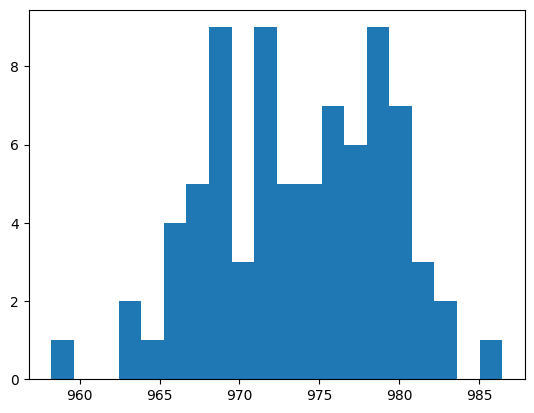

In [88]:
val = 20
n, b, p = plt.hist(peaks, bins=val)

In [89]:
popt, pcov = curve_fit(Gauss, b[0:len(n)], n, p0=[10, 970, 10])
print(popt)

[  7.31229186 973.38197713   6.43469772]


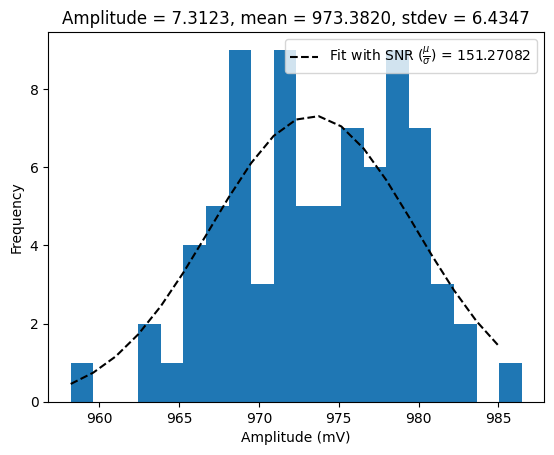

In [90]:
plt.plot(b[0:len(n)], Gauss(b[0:len(n)], *popt), "--", color="black", label=r"Fit with SNR ($\frac{\mu}{\sigma}$) = %.05f" % (popt[1]/popt[2]))
n2, b2, p2 = plt.hist(peaks, bins=b)
plt.title("Amplitude = %.04f, mean = %.04f, stdev = %.04f" % (popt[0], popt[1], popt[2]))
plt.xlabel("Amplitude (mV)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Result logs for peak height SNR method:
1. SNR for input amplitude 68 mV and gain by shaper is 115.35387 with 20 bins and Gaussian fit.
2. SNR for input amplitude 68 mV is 81.19303 with 20 bins and Gaussian fit (base case).
3. SNR for input ampltude 147 mV is 151.27082 with 20 bins and Gaussian fit.

This seems to suggest that the bulk of the noise is coming from somewhere in between the function generator and the shaper. This is where the best improvement was seen: 81 $\rightarrow$ 151 

There seems to be some improvement when the shaper gain is increased. This could mean that some noise was picked up downstream of the shaper; thus, the result after adjusting shaper gain is a bit better. 

However, this is a *very, very* rough calculation with only about ~79-80 (1 min data collection) samples for each case. 

#### SNR using each trace

Just talked to Tsuguo about this method and we're not going to pursue this anymore since this method has less statistics than the previous one.

#### How to proceed

We've narrowed down the problem to in between the function generator and the shaper. Now I'm going to go downstream and change the stage-2 gain, ie the gain on the second op-amp.

The idea is that we make the gain higher and then observe the SNR. To this end, we swapped out the 2k resistor for a 5k one. Now, the second stage gain is (1 + $\frac{5000}{255}$ ~ 20.60)

In [117]:
filename = "Feb12_Amp68mV_st025us_2ndstagebaseline.txt_dig2-usb22575_CH1_20240212144230-20.txt"
file = open(filename, "r")
length = len(file.readlines())
file.close()

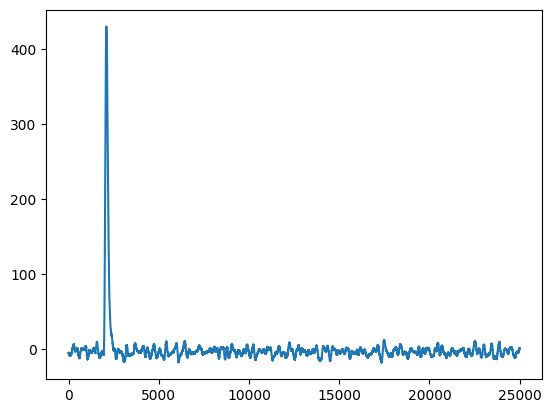

In [118]:
data = np.loadtxt(filename, skiprows=4, max_rows=1)
plt.plot(data)

In [119]:
# Doing SNR using the peak noise method
peaks = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        peak = max(data)
        peaks.append(peak)
    else:
        pass

peaks = np.array(peaks)
print(len(peaks))

79


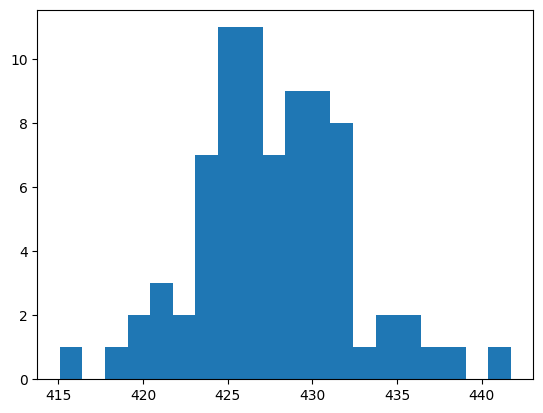

In [120]:
val = 20
n, b, p = plt.hist(peaks, bins=val)

In [122]:
popt, pcov = curve_fit(Gauss, b[0:len(n)], n, p0=[16, 430, 10])
print(popt)

[ 10.22780985 426.77815099   3.98224217]


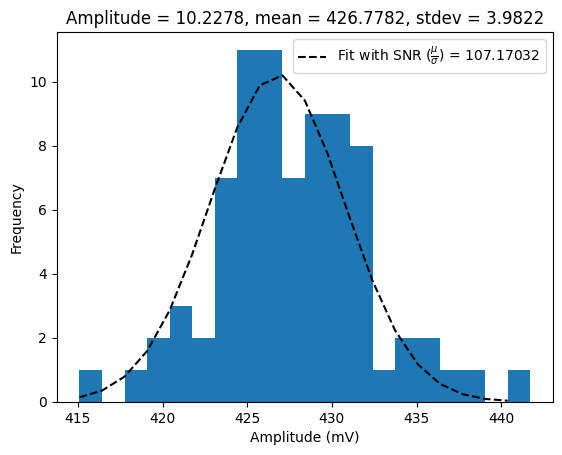

In [123]:
plt.plot(b[0:len(n)], Gauss(b[0:len(n)], *popt), "--", color="black", label=r"Fit with SNR ($\frac{\mu}{\sigma}$) = %.05f" % (popt[1]/popt[2]))
n2, b2, p2 = plt.hist(peaks, bins=b)
plt.title("Amplitude = %.04f, mean = %.04f, stdev = %.04f" % (popt[0], popt[1], popt[2]))
plt.xlabel("Amplitude (mV)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Result logs for changing second stage gain

All results below are with # of bins = 20.

1. Baseline SNR is 107.17046 for R1 = 2000 $\Omega$ (offset 50%). 
2. SNR with R1 = 5000 $\Omega$ (offset = 43%) is 84.89963.

So the SNR got worse when we amplified the second stage gain. I also visually confirmed that the noise got amplified after the gain was increased; this indicates that the noise occurs *BEFORE* the second stage gain as well. 

Image here:
![here](IMG_5680.JPG)

The yellow cursors above show the average peak-to-peak noise level when we had the higher gain on. Once we reinstalled the 2000 $\Omega$ resistor, we see that the amplitude of the noise has also gone back down. This makes it very clear that the noise occured before the second stage gain. 

#### Changing the first stage gain

Now, to change the first stage gain, we note that 
$ G = \frac{C_{inj}}{C_{FB}} $.

We can change the first stage gain without having to change the $\tau$ of the preamp. To this end, we might replace the 1 pF with something like 5 pF to get a new gain of $ G = \frac{5}{0.5} = 10 $. If the noise is amplified as well, then we can conclude that the noise occurs before the first stage gain and after the function generator. 

We actually changed it to (an oversized) 10 pF capacitor, which results in a gain of $\frac{10}{0.5} = 20$. 

In [38]:
filename = "Feb14_Amp68mV_st025us_1ststagebaseline_dig2-usb22575_CH1_20240214140640-03.txt" # put file names here
file = open(filename, "r")
length = len(file.readlines())
file.close()

In [39]:
# Doing SNR using the peak noise method
peaks = []
waveforms = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        peak = max(data)
        peaks.append(peak)
        waveforms.append(data)
    else:
        pass

peaks = np.array(peaks)
print(len(waveforms[0]))
print(len(peaks))

25000
79


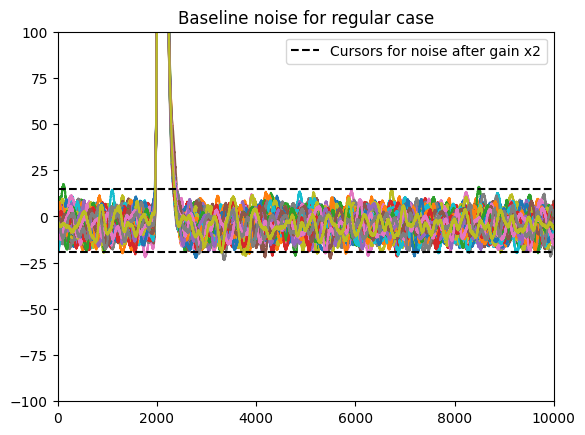

In [41]:
for wave in waveforms:
    plt.plot(wave)
plt.xlim(0, 10000)
plt.ylim(-100, 100)
plt.hlines(15, 0, 10000, color="black", ls="--", label="Cursors for noise after gain x2")
plt.hlines(-19, 0, 10000, color="black", ls="--")
plt.title("Baseline noise for regular case")
plt.legend()

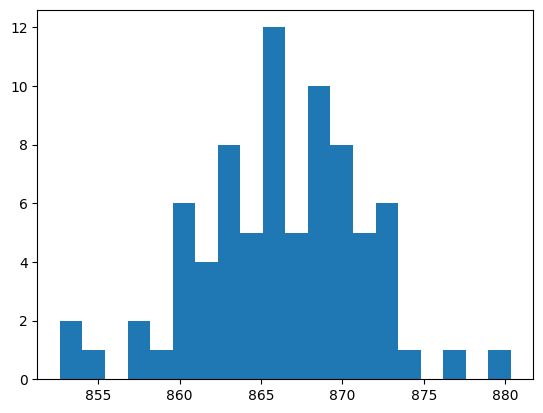

In [16]:
val = 20
n, b, p = plt.hist(peaks, bins=val)

In [17]:
popt, pcov = curve_fit(Gauss, b[0:len(n)], n, p0=[12, 865, 10])
print(popt)

[  8.86153125 865.97150083   4.81469075]


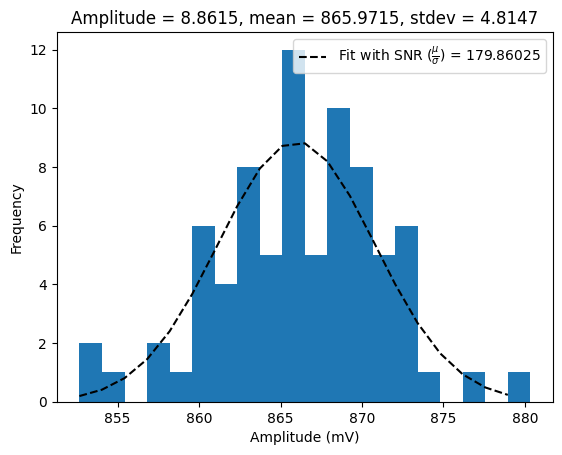

In [18]:
plt.plot(b[0:len(n)], Gauss(b[0:len(n)], *popt), "--", color="black", label=r"Fit with SNR ($\frac{\mu}{\sigma}$) = %.05f" % (popt[1]/popt[2]))
n2, b2, p2 = plt.hist(peaks, bins=b)
plt.title("Amplitude = %.04f, mean = %.04f, stdev = %.04f" % (popt[0], popt[1], popt[2]))
plt.xlabel("Amplitude (mV)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Result logs for first stage gain
1. Baseline reading looks to have SNR ~ 86.70
2. With x2 gain, we see that the SNR has gone up to ~179.86

Hmm...it seems to be like we've improved our signal to noise ratio? The noise doesn't seem to be amplified even after the gain. 

So is the noise between the first stage and second stage?

#### A quick RMS study across our circuit, going upstream.

In [116]:
shaper_base = "Feb12_Amp68mV_st025us.txt_dig2-usb22575_CH1_20240212123702-13.txt"
shaper_gain = "Feb12_Amp68mV_st025us_shpgain.txt_dig2-usb22575_CH1_20240212124620-15.txt"
second_base = "Feb12_Amp68mV_st025us_2ndstagebaseline.txt_dig2-usb22575_CH1_20240212144230-20.txt"
second_gain = "Feb12_Amp68mV_st025us_2ndstagegainw5k_43offset.txt_dig2-usb22575_CH1_20240212151553-22.txt"
first_base = "Feb14_Amp68mV_st025us_1ststagebaseline_dig2-usb22575_CH1_20240214140640-03.txt"
first_gain = "Feb15_Amp68mV_st025us_1ststagegain2_dig2-usb22575_CH1_20240215111612-04.txt"
vd_base = "Feb15_Amp68mV_st025us_r1500r250_dig2-usb22575_CH1_20240215132347-27.txt"
bnc_base = "Feb15_Amp68mV_st025us_baselinewBNC_dig2-usb22575_CH1_20240215132714-29.txt"

In [122]:
# Finding length of desired file
filename = bnc_base # put file names here
file = open(filename, "r")
length = len(file.readlines())
file.close()

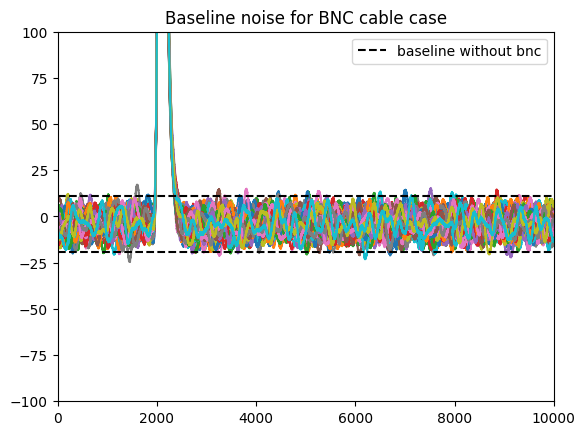

In [124]:
waveforms = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        waveforms.append(data)
    else:
        pass
for wave in waveforms:
    plt.plot(wave)
plt.xlim(0, 10000)
plt.ylim(-100, 100)
plt.hlines(11, 0, 10000, color="black", ls="--", label="baseline without bnc")
plt.hlines(-19, 0, 10000, color="black", ls="--")
plt.title("Baseline noise for BNC cable case")
plt.legend()

In [87]:
baseline = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        baseline.append(np.mean(data[4000:]))
    else:
        pass
print(baseline)

[-2.6409667619047625, -3.1403354285714284, -2.8395070000000002, -2.842691142857143, -2.759646571428571, -2.4092329047619048, -3.175524857142857, -2.801751952380952, -3.487854285714286, -2.7751450952380954, -3.185056619047619, -3.328991095238096, -3.3908390476190475, -3.675972619047619, -3.463658047619048, -2.9879497619047624, -4.3461424285714285, -4.822548952380952, -4.664812095238095, -4.420604428571428, -2.961244, -3.8406357619047617, -3.629959761904762, -3.879509761904762, -3.5928055238095236, -3.489475142857142, -4.310862952380953, -3.8059039523809526, -4.193051142857143, -3.844806, -4.155803904761905, -3.6715189523809526, -3.3265258571428573, -4.054352714285715, -3.860382761904762, -3.6729715238095237, -3.1993579523809528, -4.050107190476191, -4.374328809523809, -3.968990523809524, -3.3127633333333333, -4.176451380952381, -3.776154285714286, -3.3694741428571424, -4.020643904761904, -4.201627809523809, -3.8600993333333338, -3.663432380952382, -3.370294904761905, -4.001815095238095,

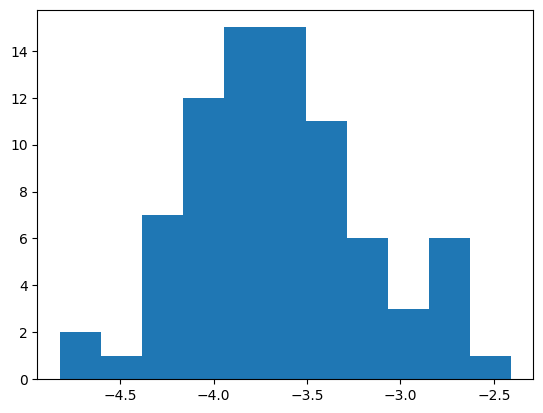

In [88]:
# Histogram for baseline
n, b, p = plt.hist(baseline, bins=11)


[15.17722159 -3.82880763  0.44081218]


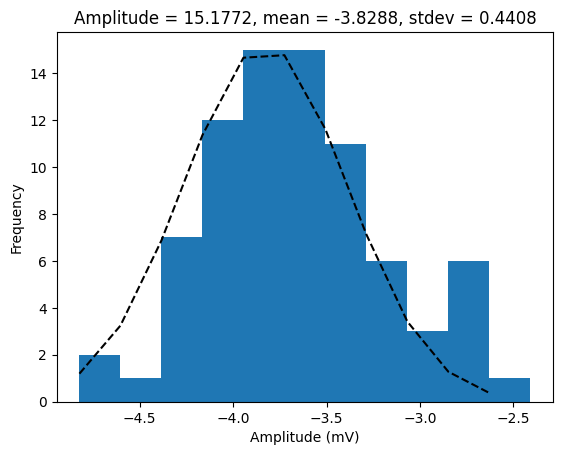

In [90]:
popt, pcov = curve_fit(Gauss, b[0:len(n)], n, p0=[15, -3.8, 0.5])
print(popt)
plt.plot(b[0:len(n)], Gauss(b[0:len(n)], *popt), "--", color="black")
n2, b2, p2 = plt.hist(baseline, bins=b)
plt.title("Amplitude = %.04f, mean = %.04f, stdev = %.04f" % (popt[0], popt[1], popt[2]))
plt.xlabel("Amplitude (mV)")
plt.ylabel("Frequency")
plt.show()

#### Changing the voltage divider
Now we look to see if the noise is before or after the divider. If it's before, then it must be some pickup noise from the cable (SMA currently). We could additionally switch that cable to BNC to check. 